# Modelling Notebook

## Modelling Dashboard

Uses Cleaned Preprocessed Data Without Sensitive Information. <br/>
Preprocessing of Sensitive Data Is Handled Separately.

In [1]:
# General
import random
random.seed(42)
import pickle
import numpy as np
import pandas as pd
from scipy.stats import randint

# Visualisation
import matplotlib.pyplot as plt
import scikitplot as skplt

# Evaluation Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Warnings
import warnings
warnings.filterwarnings('ignore')

### Modelling Job Duration Prediction

#### Import Dataset

In [2]:
# Read Dataset
aa_job_duration_df = pd.read_csv('./datasets/aa_job_duration.csv')

In [3]:
# Split Training & Testing Dataset
# Dependent Variable
target_list = ['duration']

# Independent Variables
feature_list = ['id', 'date', 'delay', 'category', 'equipment', 'items', 'service', 'staff']

# Selecting Target Variable and Features from Dataset
X = aa_job_duration_df[feature_list]
y = aa_job_duration_df[target_list]

# Split Training & Testing Dataset (80:20 Split)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

# Reset Indexes
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

#### Feature Engineering

In [4]:
# Perform one-hot encoding for the 'category', 'equipment', and 'service' columns
X_train_one_hot_category = pd.get_dummies(X_train['category'], prefix='category')
X_train_one_hot_equipment = pd.get_dummies(X_train['equipment'], prefix='equipment')
X_train_one_hot_service = pd.get_dummies(X_train['service'], prefix='service')

# Concatenate the one-hot encoded DataFrames with the original DataFrame
X_train_encoded = pd.concat([X_train, X_train_one_hot_category, X_train_one_hot_equipment, X_train_one_hot_service], axis=1)

# Drop the original categorical columns if you no longer need them
X_train_encoded = X_train_encoded.drop(columns=['category', 'equipment', 'service'])

In [5]:
# Perform one-hot encoding for the 'category', 'equipment', and 'service' columns
X_test_one_hot_category = pd.get_dummies(X_test['category'], prefix='category')
X_test_one_hot_equipment = pd.get_dummies(X_test['equipment'], prefix='equipment')
X_test_one_hot_service = pd.get_dummies(X_test['service'], prefix='service')

# Concatenate the one-hot encoded DataFrames with the original DataFrame
X_test_encoded = pd.concat([X_test, X_test_one_hot_category, X_test_one_hot_equipment, X_test_one_hot_service], axis=1)

# Drop the original categorical columns if you no longer need them
X_test_encoded = X_test_encoded.drop(columns=['category', 'equipment', 'service'])

#### Feature Selection

In [6]:
# Keep Selected Features
X_train_selected = X_train_encoded.drop(columns=['date', 'delay', 'id'])
X_test_selected = X_test_encoded.drop(columns=['date', 'delay', 'id'])

#### Machine Learning Modelling

In [7]:
# Evaluation 
def evaluate(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r_squared = r2_score(y_test, y_pred)
    
    print("Mean Absolute Error (MAE):", mae)
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("R-squared Coefficient (R^2):", r_squared)

# Features Used
feature_names = X_train_selected.columns

##### Baseline Modelling

In [8]:
## Model Training
# Linear Regression
reg_lr = LinearRegression().fit(X_train_selected, y_train)
y_pred_lr = reg_lr.predict(X_test_selected)

evaluate(y_test, y_pred_lr)

Mean Absolute Error (MAE): 12.986041392363397
Mean Squared Error (MSE): 375.61222609318423
Root Mean Squared Error (RMSE): 19.380717894164402
R-squared Coefficient (R^2): 0.9473023204662383


In [9]:
# Decision Tree Regressor
reg_dtr = DecisionTreeRegressor(random_state=42).fit(X_train_selected, y_train)
y_pred_dtr = reg_dtr.predict(X_test_selected)

evaluate(y_test, y_pred_dtr)

Mean Absolute Error (MAE): 9.898818651846055
Mean Squared Error (MSE): 211.43639172009668
Root Mean Squared Error (RMSE): 14.540852510086768
R-squared Coefficient (R^2): 0.9703358771663723


In [10]:
## Hyperparameter Tuning
# Use RandomSearch 
param_dist = {
    "max_depth": randint(1, 20),  
    "min_samples_split": randint(2, 40),  
    "min_samples_leaf": randint(1, 20), 
    "max_features": [1.0, "sqrt", "log2", None],
}

rscv_dtr = RandomizedSearchCV(estimator = DecisionTreeRegressor(random_state=42), param_distributions = param_dist, n_iter = 100, scoring = 'neg_root_mean_squared_error', cv = 5, n_jobs = -1).fit(X_train_selected, y_train)

best_params_dtr = rscv_dtr.best_params_
print("Best Parameters For Decision Tree:", best_params_dtr)

y_pred_rscv_dtr = rscv_dtr.predict(X_test_selected)

evaluate(y_test, y_pred_rscv_dtr)

Best Parameters For Decision Tree: {'max_depth': 9, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 38}
Mean Absolute Error (MAE): 9.95478032403877
Mean Squared Error (MSE): 212.75163702135387
Root Mean Squared Error (RMSE): 14.586008262076156
R-squared Coefficient (R^2): 0.970151350757009


##### Advanced Modelling

In [11]:
# Random Forest Regressor
reg_rfr = RandomForestRegressor(random_state=42).fit(X_train_selected, y_train)
y_pred_rfr = reg_rfr.predict(X_test_selected)

evaluate(y_test, y_pred_rfr)

Mean Absolute Error (MAE): 9.902402738743598
Mean Squared Error (MSE): 211.4888842641694
Root Mean Squared Error (RMSE): 14.542657400357385
R-squared Coefficient (R^2): 0.9703285125624715


In [12]:
# XG Boost Regressor
reg_xgbr = XGBRegressor(random_state=42).fit(X_train_selected, y_train)
y_pred_xgbr = reg_xgbr.predict(X_test_selected)

evaluate(y_test, y_pred_xgbr)

Mean Absolute Error (MAE): 9.898744374690203
Mean Squared Error (MSE): 211.43350985223458
Root Mean Squared Error (RMSE): 14.540753414188503
R-squared Coefficient (R^2): 0.9703362814869415


In [13]:
# LightGBM Regressor
reg_lgbmr = lgb.LGBMRegressor(random_state=42).fit(X_train_selected, y_train)
y_pred_lgbmr = reg_lgbmr.predict(X_test_selected)

evaluate(y_test, y_pred_lgbmr)

Mean Absolute Error (MAE): 9.907213442153378
Mean Squared Error (MSE): 211.67175708913888
Root Mean Squared Error (RMSE): 14.548943504225276
R-squared Coefficient (R^2): 0.9703028558536207


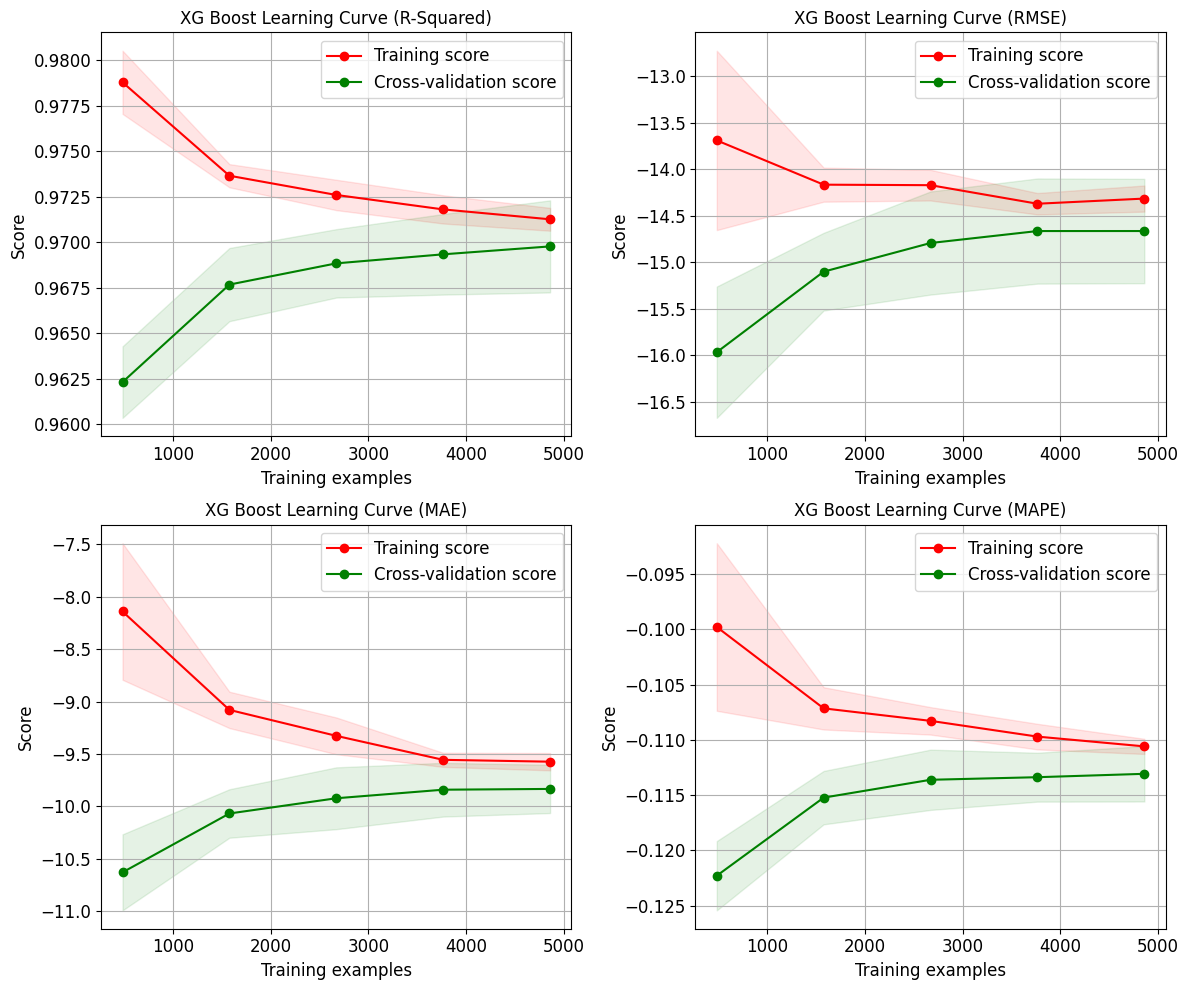

In [14]:
## Cross Validation
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  
ax1, ax2, ax3, ax4 = axes.flatten() 
y_train_reshaped = np.ravel(y_train)

# Learning curves
skplt.estimators.plot_learning_curve(XGBRegressor(random_state=42), X_train_selected, y_train_reshaped,
                                     cv=5, shuffle=True, scoring="r2", n_jobs=-1,
                                     figsize=(6, 4), title_fontsize="large", text_fontsize="large",
                                     title="XG Boost Learning Curve (R-Squared)", ax=ax1)
skplt.estimators.plot_learning_curve(XGBRegressor(random_state=42), X_train_selected, y_train_reshaped,
                                     cv=5, shuffle=True, scoring="neg_root_mean_squared_error", n_jobs=-1,
                                     figsize=(6, 4), title_fontsize="large", text_fontsize="large",
                                     title="XG Boost Learning Curve (RMSE)", ax=ax2)
skplt.estimators.plot_learning_curve(XGBRegressor(random_state=42), X_train_selected, y_train_reshaped,
                                     cv=5, shuffle=True, scoring="neg_mean_absolute_error", n_jobs=-1,
                                     figsize=(6, 4), title_fontsize="large", text_fontsize="large",
                                     title="XG Boost Learning Curve (MAE)", ax=ax3)
skplt.estimators.plot_learning_curve(XGBRegressor(random_state=42), X_train_selected, y_train_reshaped,
                                     cv=5, shuffle=True, scoring="neg_mean_absolute_percentage_error", n_jobs=-1,
                                     figsize=(6, 4), title_fontsize="large", text_fontsize="large",
                                     title="XG Boost Learning Curve (MAPE)", ax=ax4)

plt.tight_layout()
plt.show()

In [15]:
## Hyperparameter Tuning
# Use Grid Search
y_train_reshaped = np.ravel(y_train)

params = { 
    'max_depth': [5, 10, 12, 15, 17, 20],     
    'min_samples_split': [2, 5, 10, 15, 20, 40], 
    'min_samples_leaf': [1, 3, 5, 7, 10, 20],
    "max_features": [1.0, None],
}

gscv_rfr = GridSearchCV(estimator=RandomForestRegressor(random_state=42), 
                        param_grid=params, 
                        scoring='neg_root_mean_squared_error', 
                        n_jobs=-1)
gscv_rfr.fit(X_train_selected, y_train_reshaped)

best_params_rfr = gscv_rfr.best_params_
print("Best Parameters For Random Forest:", best_params_rfr)

y_pred_gscv_rfr = gscv_rfr.predict(X_test_selected)

evaluate(y_test, y_pred_gscv_rfr)

Best Parameters For Random Forest: {'max_depth': 10, 'max_features': 1.0, 'min_samples_leaf': 7, 'min_samples_split': 40}
Mean Absolute Error (MAE): 9.897964774597456
Mean Squared Error (MSE): 211.38157846139515
Root Mean Squared Error (RMSE): 14.538967585815547
R-squared Coefficient (R^2): 0.970343567362113


<Axes: title={'center': 'Random Forest Regressor with Hyperparameter Tuning Feature Importance'}>

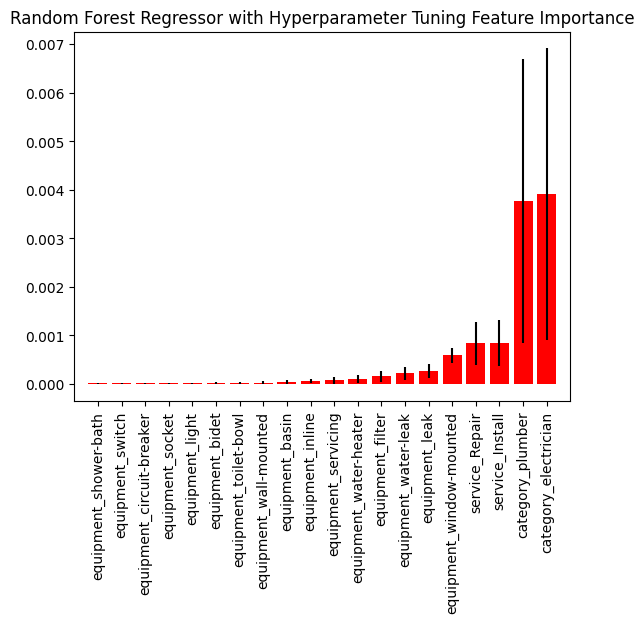

In [16]:
## Feature Evaluation
skplt.estimators.plot_feature_importances(gscv_rfr.best_estimator_, feature_names = feature_names,
                                         title="Random Forest Regressor with Hyperparameter Tuning Feature Importance",
                                         x_tick_rotation=90, order="ascending")

In [17]:
# Dump Model Into Pickle
pickle.dump(gscv_rfr, open('../public/analytics/advanced/job-duration-model.pkl', 'wb'))

### Modelling Service Price Prediction

#### Import Dataset

In [18]:
# Read Dataset
aa_service_price_df = pd.read_csv('./datasets/aa_service_price.csv')

In [19]:
# Split Training & Testing Dataset
# Dependent Variable
target_list = ['price']

# Independent Variables
feature_list = ['id', 'date', 'category', 'equipment', 'items', 'service']

# Selecting Target Variable and Features from Dataset
X = aa_service_price_df[feature_list]
y = aa_service_price_df[target_list]

# Split Training & Testing Dataset (80:20 Split)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

# Reset Indexes
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

#### Feature Engineering

In [20]:
# Perform one-hot encoding for the 'category', 'equipment', and 'service' columns
X_train_one_hot_category = pd.get_dummies(X_train['category'], prefix='category')
X_train_one_hot_equipment = pd.get_dummies(X_train['equipment'], prefix='equipment')
X_train_one_hot_service = pd.get_dummies(X_train['service'], prefix='service')

# Concatenate the one-hot encoded DataFrames with the original DataFrame
X_train_encoded = pd.concat([X_train, X_train_one_hot_category, X_train_one_hot_equipment, X_train_one_hot_service], axis=1)

# Drop the original categorical columns if you no longer need them
X_train_encoded = X_train_encoded.drop(columns=['category', 'equipment', 'service'])

In [21]:
# Perform one-hot encoding for the 'category', 'equipment', and 'service' columns
X_test_one_hot_category = pd.get_dummies(X_test['category'], prefix='category')
X_test_one_hot_equipment = pd.get_dummies(X_test['equipment'], prefix='equipment')
X_test_one_hot_service = pd.get_dummies(X_test['service'], prefix='service')

# Concatenate the one-hot encoded DataFrames with the original DataFrame
X_test_encoded = pd.concat([X_test, X_test_one_hot_category, X_test_one_hot_equipment, X_test_one_hot_service], axis=1)

# Drop the original categorical columns if you no longer need them
X_test_encoded = X_test_encoded.drop(columns=['category', 'equipment', 'service'])

#### Feature Selection

In [22]:
# Keep Selected Features
X_train_selected = X_train_encoded.drop(columns=['date', 'id'])
X_test_selected = X_test_encoded.drop(columns=['date', 'id'])

#### Machine Learning Modelling

##### Baseline Modelling

In [23]:
## Model Training
# Linear Regression
reg_lr = LinearRegression().fit(X_train_selected, y_train)
y_pred_lr = reg_lr.predict(X_test_selected)

evaluate(y_test, y_pred_lr)

Mean Absolute Error (MAE): 55.223996050032916
Mean Squared Error (MSE): 5728.921782422646
Root Mean Squared Error (RMSE): 75.68964118307503
R-squared Coefficient (R^2): 0.7707830089398304


In [24]:
# Decision Tree Regressor
reg_dtr = DecisionTreeRegressor(random_state=42).fit(X_train_selected, y_train)
y_pred_dtr = reg_dtr.predict(X_test_selected)

evaluate(y_test, y_pred_dtr)

Mean Absolute Error (MAE): 20.183039236344875
Mean Squared Error (MSE): 1135.3047455673955
Root Mean Squared Error (RMSE): 33.694283574033676
R-squared Coefficient (R^2): 0.9545758961985263


In [25]:
## Hyperparameter Tuning
# Use RandomSearch 
param_dist = {
    "max_depth": randint(1, 20),  
    "min_samples_split": randint(2, 40),  
    "min_samples_leaf": randint(1, 20), 
    "max_features": [1.0, "sqrt", "log2", None],
}

rscv_dtr = RandomizedSearchCV(estimator = DecisionTreeRegressor(random_state=42), param_distributions = param_dist, n_iter = 100, scoring = 'neg_root_mean_squared_error', cv = 5, n_jobs = -1).fit(X_train_selected, y_train)

best_params_dtr = rscv_dtr.best_params_
print("Best Parameters For Decision Tree:", best_params_dtr)

y_pred_rscv_dtr = rscv_dtr.predict(X_test_selected)

evaluate(y_test, y_pred_rscv_dtr)

Best Parameters For Decision Tree: {'max_depth': 17, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 11}
Mean Absolute Error (MAE): 20.132070640312808
Mean Squared Error (MSE): 1116.9622398904455
Root Mean Squared Error (RMSE): 33.4209850227435
R-squared Coefficient (R^2): 0.9553097889133255


##### Advanced Modelling

In [26]:
# Random Forest Regressor
reg_rfr = RandomForestRegressor(random_state=42).fit(X_train_selected, y_train)
y_pred_rfr = reg_rfr.predict(X_test_selected)

evaluate(y_test, y_pred_rfr)

Mean Absolute Error (MAE): 20.19506956993985
Mean Squared Error (MSE): 1135.9543624229764
Root Mean Squared Error (RMSE): 33.70392206291393
R-squared Coefficient (R^2): 0.9545499047071719


In [27]:
# XG Boost Regressor
reg_xgbr = XGBRegressor(random_state=42).fit(X_train_selected, y_train)
y_pred_xgbr = reg_xgbr.predict(X_test_selected)

evaluate(y_test, y_pred_xgbr)

Mean Absolute Error (MAE): 20.182140376710674
Mean Squared Error (MSE): 1135.245766065041
Root Mean Squared Error (RMSE): 33.69340834740589
R-squared Coefficient (R^2): 0.9545782559975562


In [28]:
# LightGBM Regressor
reg_lgbmr = lgb.LGBMRegressor(random_state=42).fit(X_train_selected, y_train)
y_pred_lgbmr = reg_lgbmr.predict(X_test_selected)

evaluate(y_test, y_pred_lgbmr)

Mean Absolute Error (MAE): 20.138352924469842
Mean Squared Error (MSE): 1115.5626321497307
Root Mean Squared Error (RMSE): 33.40003940341584
R-squared Coefficient (R^2): 0.9553657879105497


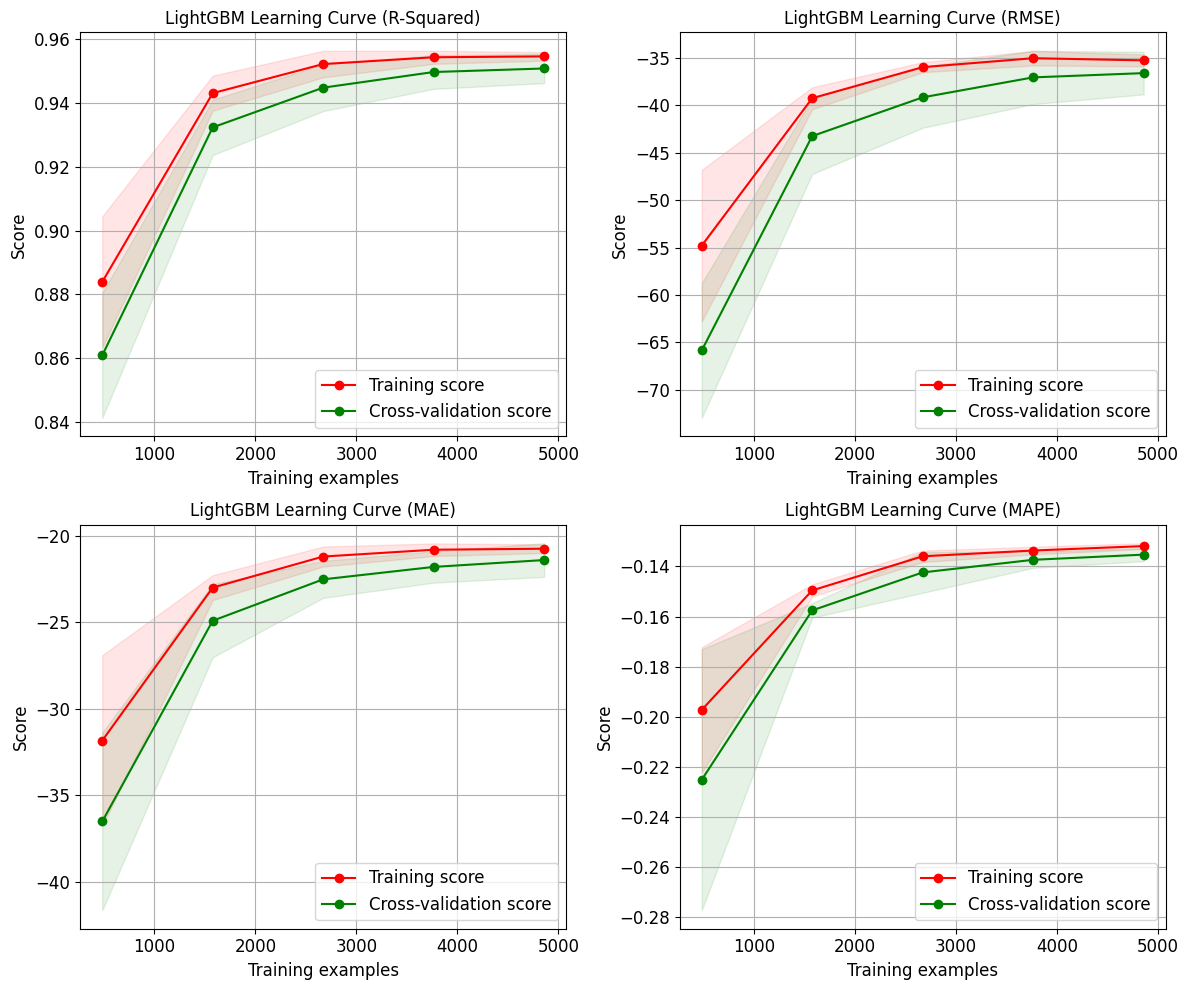

In [29]:
## Cross Validation
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  
ax1, ax2, ax3, ax4 = axes.flatten() 
y_train_reshaped = np.ravel(y_train)

# Learning curves
skplt.estimators.plot_learning_curve(lgb.LGBMRegressor(random_state=42), X_train_selected, y_train_reshaped,
                                     cv=5, shuffle=True, scoring="r2", n_jobs=-1,
                                     figsize=(6, 4), title_fontsize="large", text_fontsize="large",
                                     title="LightGBM Learning Curve (R-Squared)", ax=ax1)
skplt.estimators.plot_learning_curve(lgb.LGBMRegressor(random_state=42), X_train_selected, y_train_reshaped,
                                     cv=5, shuffle=True, scoring="neg_root_mean_squared_error", n_jobs=-1,
                                     figsize=(6, 4), title_fontsize="large", text_fontsize="large",
                                     title="LightGBM Learning Curve (RMSE)", ax=ax2)
skplt.estimators.plot_learning_curve(lgb.LGBMRegressor(random_state=42), X_train_selected, y_train_reshaped,
                                     cv=5, shuffle=True, scoring="neg_mean_absolute_error", n_jobs=-1,
                                     figsize=(6, 4), title_fontsize="large", text_fontsize="large",
                                     title="LightGBM Learning Curve (MAE)", ax=ax3)
skplt.estimators.plot_learning_curve(lgb.LGBMRegressor(random_state=42), X_train_selected, y_train_reshaped,
                                     cv=5, shuffle=True, scoring="neg_mean_absolute_percentage_error", n_jobs=-1,
                                     figsize=(6, 4), title_fontsize="large", text_fontsize="large",
                                     title="LightGBM Learning Curve (MAPE)", ax=ax4)

plt.tight_layout()
plt.show()

In [30]:
## Hyperparameter Tuning
# Random Search
params = { 
    'max_depth': randint(5, 20),  
    'num_leaves': randint(20, 500),
    'min_data_in_leaf': randint(20, 500),
    'learning_rate': [0.01, 0.05, 0.10, 0.50],
}

rscv_lgbm = RandomizedSearchCV(estimator = lgb.LGBMRegressor(random_state=42), param_distributions = params,
                               scoring = 'neg_root_mean_squared_error', n_jobs = -1).fit(X_train_selected, y_train)

best_params_lgbm = rscv_lgbm.best_params_
print("Best Parameters For LightGBM:", best_params_lgbm)

y_pred_rscv_lgbm = rscv_lgbm.predict(X_test_selected)

evaluate(y_test, y_pred_rscv_lgbm)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
Best Parameters For LightGBM: {'learning_rate': 0.5, 'max_depth': 12, 'min_data_in_leaf': 20, 'num_leaves': 471}
Mean Absolute Error (MAE): 20.16597827334482
Mean Squared Error (MSE): 1132.9503482684252
Root Mean Squared Error (RMSE): 33.659327804762015
R-squared Coefficient (R^2): 0.9546700967977186


<Axes: title={'center': 'LightGBM Regressor with Hyperparameter Tuning Feature Importance'}>

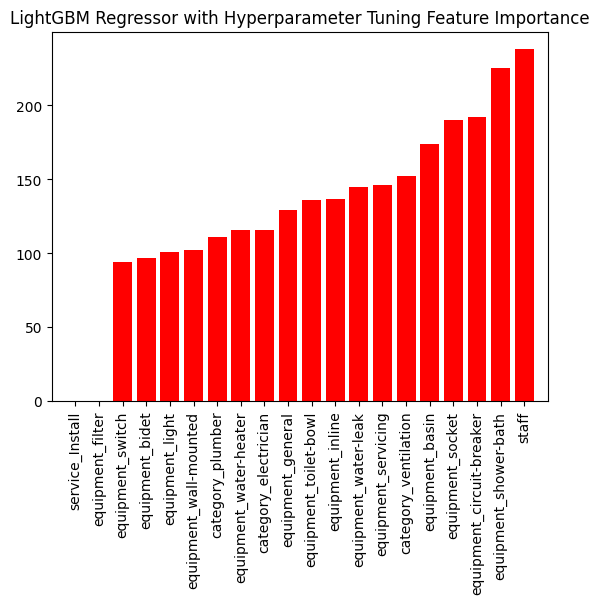

In [31]:
## Feature Evaluation
skplt.estimators.plot_feature_importances(rscv_lgbm.best_estimator_, feature_names = feature_names,
                                         title="LightGBM Regressor with Hyperparameter Tuning Feature Importance",
                                         x_tick_rotation=90, order="ascending")

In [32]:
# Dump Model Into Pickle
pickle.dump(reg_lgbmr, open('../public/analytics/advanced/service-price-model.pkl', 'wb'))